# Train Titanic

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [178]:
df=pd.read_csv("train_titanic.csv")
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [179]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [180]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Vemos valores nulls. 

Valores nulls: 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


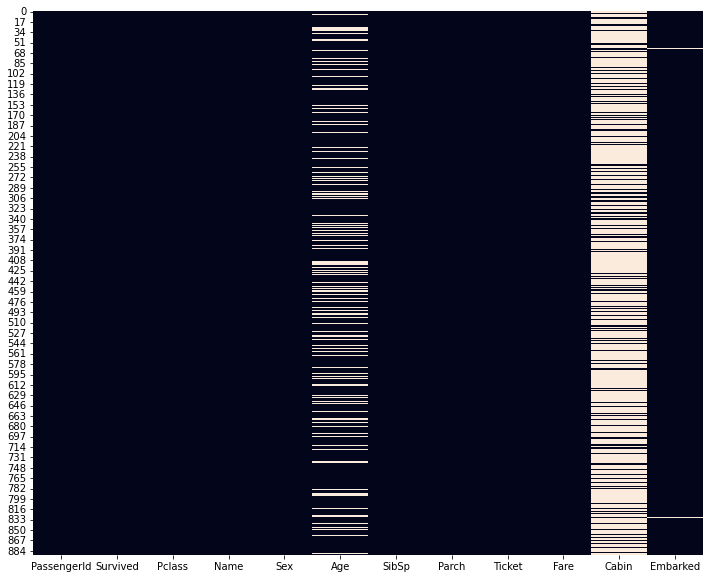

In [181]:
print('Valores nulls: \n')
print(df.isna().sum())
plt.figure(figsize=(12,10))
sns.heatmap(df.isna(),cbar=False)
plt.show()

## Completamos nulls y preparamos todos los datos


In [182]:
#completamos los faltantes (2) con la variable mas comun.
df['Embarked']=df['Embarked'].fillna('S')
#Completamos con la media "Age"
col=df['Age'].fillna(df['Age'].mean())
# y reemplazamos columna  "Age" x "N_age"
df["N_age"]=col
df=df.drop(['Age'],axis=1)

In [183]:
df1=df.copy() #dejamos listo [df] para los modelos.

## Vemos correlacion con la variable objetivo "Survived"  y heatmap.

Sex           -0.543351
Pclass        -0.338481
N_age         -0.069809
SibSp         -0.035322
PassengerId   -0.005007
Parch          0.081629
Fare           0.257307
Survived       1.000000
Name: Survived, dtype: float64


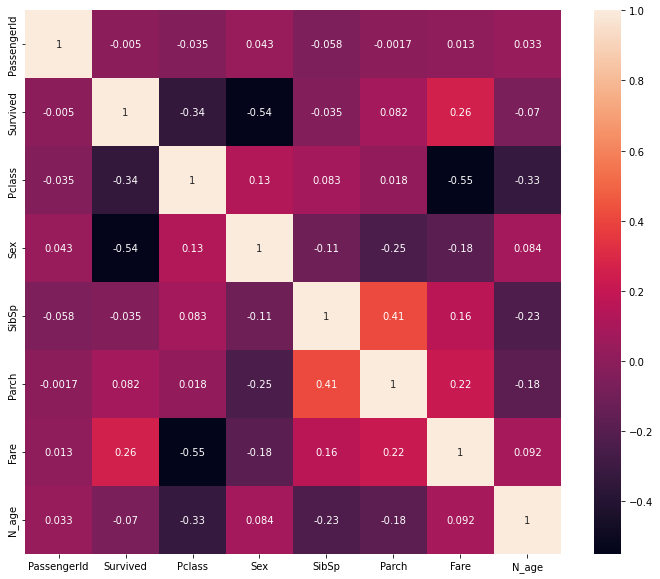

In [184]:
df1['Sex']=df1['Sex'].map({'female':0,'male':1}).astype(int)# Le damos valores numericos a la "Sex" para ver Correlatividad
correlation = df1.corr()
print(correlation["Survived"].sort_values(ascending=True))
plt.figure(figsize=(12,10))
sns.heatmap(correlation,annot=True)
plt.show()

## Vemos las dos variables con mas correlación 'Sex' y 'Pclass' 


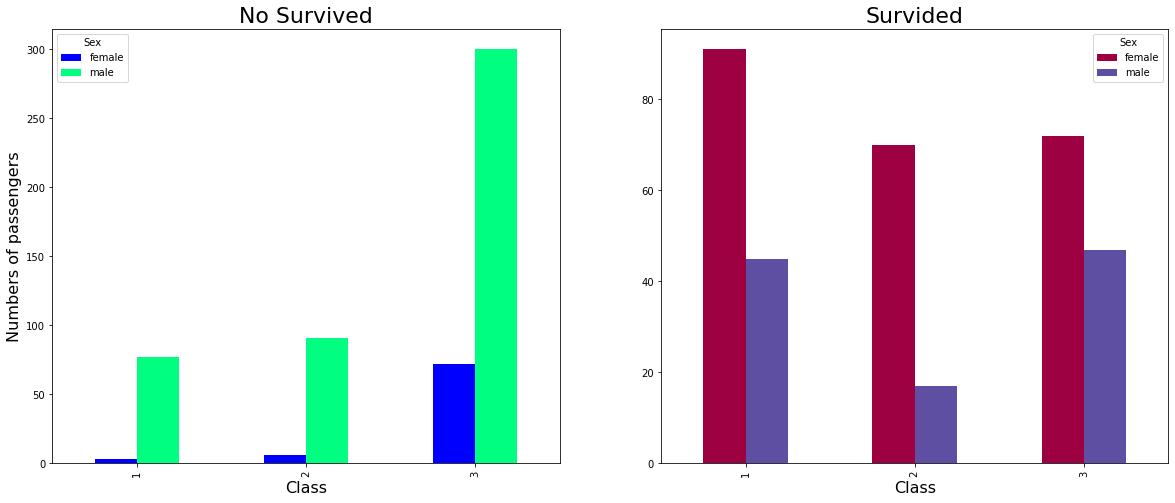

- de 342 passengers que sobrevivieron solo 109 eran hombres mientras que  233 eran mujeres
- de 549 passengers que no sobrevivieron 468 eran hombres mientras que  81 eran mujeres
- de los passengers no sobrevientes 300 eran hombres de 3ra clase, mas de una 3ra parte del total
 y mas del 50% de los no sobrevivientes


In [197]:
#preparamos variables para plot
df['Survived']= df['Survived'].apply(lambda x: str(x).replace('0','No'))
df['Survived']= df['Survived'].apply(lambda x: str(x).replace('1','Yes'))

survived=df[df["Survived"]=="Yes"]
nosurvived=df[df["Survived"]=="No"]

survived_plot=survived.groupby(['Pclass','Sex']).count()['PassengerId']
nosurvived_plot=nosurvived.groupby(['Pclass','Sex']).count()['PassengerId']

male_sur=survived[survived['Sex']=='male']
female_sur=survived[survived['Sex']=='female']
nosur_ma=nosurvived[nosurvived['Sex']=='male']
nosur_fe=nosurvived[nosurvived['Sex']=='female']
nosur_ma_3=nosurvived[(nosurvived['Sex']=='male')&(nosurvived['Pclass']==3)]
#plot
fig,ax = plt.subplots(1,2,figsize=(20,8))
ax = ax.ravel()
(survived_plot.unstack(level=1)).plot.bar(cmap='Spectral',ax=ax[1])
(nosurvived_plot.unstack(level=1)).plot.bar(cmap='winter',ax=ax[0])
ax[1].set_title('Survided',fontsize=22)
ax[0].set_title('No Survived',fontsize=22)
ax[0].set_xlabel('Class',fontsize=16)
ax[1].set_xlabel('Class',fontsize=16)
ax[0].set_ylabel('Numbers of passengers',fontsize=16)
plt.show()

print("- de", survived.shape[0], 'passengers que sobrevivieron solo', male_sur.shape[0], 'eran hombres mientras que ' ,
      female_sur.shape[0],'eran mujeres')
print("- de", nosurvived.shape[0], 'passengers que no sobrevivieron', nosur_ma.shape[0], 'eran hombres mientras que ' ,
      nosur_fe.shape[0],'eran mujeres')
print("- de los passengers no sobrevientes", nosur_ma_3.shape[0], 'eran hombres de 3ra clase, mas de una 3ra parte del total\n' 
       ' y mas del 50% de los no sobrevivientes')

- Vemos una gran correlacion entre la variable objetivo "Survived" con el grupo de datos Class=3 y Sex= male


# Features Pipeline

In [198]:
# Volvemos la variable objetivo a int64
df['Survived'].replace('No',0,inplace=True)
df['Survived'].replace('Yes',1,inplace=True)

In [199]:
#Separamos Variables
y=df['Survived']
X=df[['Pclass','Sex','N_age','SibSp','Parch','Fare','Embarked']]
X

,Pclass,Sex,N_age,SibSp,Parch,Fare,Embarked
0,3,male,22.000000,1,0,7.2500,S
1,1,female,38.000000,1,0,71.2833,C
2,3,female,26.000000,0,0,7.9250,S
3,1,female,35.000000,1,0,53.1000,S
4,3,male,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.000000,0,0,13.0000,S
887,1,female,19.000000,0,0,30.0000,S
888,3,female,29.699118,1,2,23.4500,S
889,1,male,26.000000,0,0,30.0000,C


In [200]:
# Identificación de columnas numéricas y categóricas
numeric_cols = X.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X.select_dtypes(include=['object']).columns.to_list()


numeric_transformer = Pipeline(steps=[
           ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[                                 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
    
preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
])

# Modelos a aplicar
modelos = [
    LogisticRegression(random_state=40), 
    SGDClassifier(random_state=40),
    DecisionTreeClassifier(random_state=40), 
    RandomForestClassifier(random_state=80),
    SVC(),
    GaussianNB()
]

# Pipeline
print('Scores:\n')
for model in modelos:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('clasiffier', model)])

    pipe.fit(X,y)
    scores = cross_val_score(pipe, X, y, cv=5, scoring = "accuracy")
    nombre_model = str(model).split("(")[0]   
    print(f'{nombre_model}: {np.round(scores.mean(),3)}')




Scores:

LogisticRegression: 0.787
SGDClassifier: 0.779
DecisionTreeClassifier: 0.768
RandomForestClassifier: 0.808
SVC: 0.828
GaussianNB: 0.789


In [201]:
# Separamos datos para entrenar 
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.25, random_state=42)


In [202]:
# onehot/scaler , instancias
scaler= StandardScaler()
onehot= OneHotEncoder(sparse=False)

# preparamos columnas
scaled_col_train= scaler.fit_transform(X_train[numeric_cols]) 
onehot_col_train=  onehot.fit_transform(X_train[cat_cols])

scaled_col_test = scaler.transform(X_test[numeric_cols]) 
onehot_col_test=  onehot.transform(X_test[cat_cols])

# juntamos train and test
X_train=np.concatenate([scaled_col_train, onehot_col_train],axis=1)
X_test=np.concatenate([scaled_col_test, onehot_col_test], axis=1)

## Cross validation (SVC best score)

In [205]:
parametros={'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear','rbf', 'poly']}
svc_grid=GridSearchCV(SVC(),parametros, cv=5)
svc_grid.fit(X_train, y_train)
print('best estimator:')
print(svc_grid.best_estimator_,'\n')
print('best Score:')
print(svc_grid.best_score_)

best estimator:
SVC(C=10, gamma=0.1) 

best Score:
0.8248344742453148


## Confusion Matrix

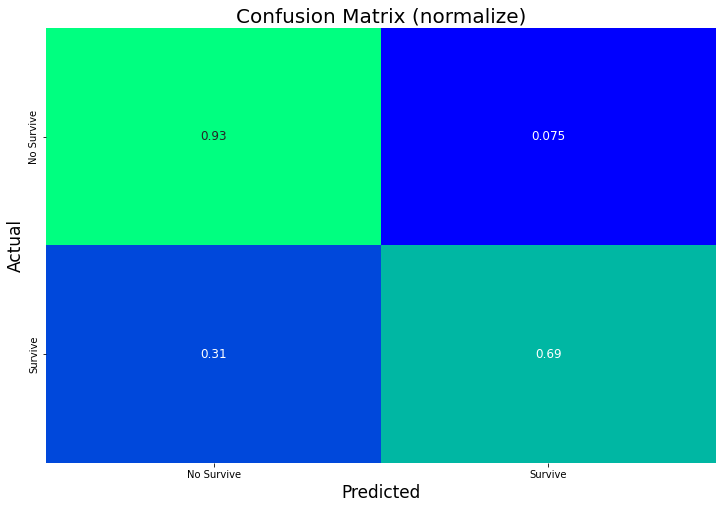

In [206]:
y_pred=svc_grid.predict(X_test)
matrix= confusion_matrix(y_test, y_pred,normalize='true')
#plot
fig,ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(matrix,annot=True,cbar= False,cmap='winter',annot_kws={"fontsize":12})
ax.set_xlabel("Predicted",fontsize='17')
ax.set_ylabel("Actual",fontsize='17')
ax.set_xticklabels(['No Survive','Survive'])
ax.set_yticklabels(['No Survive','Survive'],fontdict={'verticalalignment': 'center'})
ax.set_title('Confusion Matrix (normalize)',fontsize='20')
plt.show()

In [141]:
#Calculamos precision global con la matrix de camfusion
Precision_global=np.sum(matrix.diagonal())/np.sum(matrix)
print('Precision Global:\n')
print(round(Precision_global,3))


Precision Global:

0.805


-------------------------------------------------------------------------
## The Challenge
Submission File Format:

You should submit a csv file with exactly 418 entries plus a header row. Your submission will show an error if you have extra columns (beyond PassengerId and Survived) or rows.

The file should have exactly 2 columns:

- PassengerId (sorted in any order)
- Survived (contains your binary predictions: 1 for survived, 0 for deceased)

In [208]:
df_test=pd.read_csv("test_titanic.csv")
df_test.head(2)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [209]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


## Preparamos y dejamos listos los datos para la predicción


In [210]:
#Completamos con la media "Age"
col=df_test['Age'].fillna(df_test['Age'].mean())
# y reemplazamos columna  "Age" x "N_age"
df_test["N_age"]=col
df_test=df_test.drop(['Age'],axis=1)
df_test['Fare']=df_test['Fare'].fillna(df_test['Fare'].mean())

In [211]:
#selección de columnas
X_df_test=df_test[['Pclass','Sex','N_age','SibSp','Parch','Fare','Embarked']]

In [212]:
cat_col=['Sex', 'Embarked']
num_cols=['Pclass','N_age','SibSp','Parch','Fare']
# onehot/scaler , instancias
scaler= StandardScaler()
onehot= OneHotEncoder(sparse=False)

# preparamos columnas
scaled_col= scaler.fit_transform(X_df_test[num_cols]) 
onehot_col=  onehot.fit_transform(X_df_test[cat_col])

# concatenamos
X_df_test=np.concatenate([scaled_col, onehot_col],axis=1)

In [213]:
#predecimos con nuestro modelo entrenado
predition=pd.Series(svc_grid.predict(X_df_test))
df_test['Survived']= predition


In [214]:
Submission=df_test[['PassengerId','Survived']]
Submission.head(10)
Submission.to_csv('Submission_kaggle.csv', index= False)

## Submission_kaggle.csv
Submitted by Martin Ezequiel· Submitted an hour ago

Score: 0.77272